<a href="https://colab.research.google.com/github/MarianaSaenz/deep_learning/blob/main/CNN_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text  classification**

Authors: Jorge Cueva, Duncan Rollier, Mariana Saenz


For this assignment, you will construct a RNN network that can predict whether a user-created game review is funny. The data set was sourced from Steam for the game "Helldivers 2".

- The JSON file attached contains a list of all reviews. Only English reviews were kept
- The text for each review is found under "review". This should be used as the input
- "voted_up" indicates if the review itself was positive or negative, "votes_up" indicates how many upvotes the review received from other users, indicating the review was "helpful"
- We will use "votes_funny", the number of votes the review received indicating it is funny as our target. Note that this is a regression target that can not go lower than zero
- Experiment with hyper parameters and different RNN types discussed in class to finetune your model
- Make sure to create a train/test set and evaluate your model accordingly
- Since the target is very imbalanced, it might be easier to convert this into a binary classification problem instead, i.e. by considering reviews that got more than n funny votes as positive. Experiment and see what works
Your report should contain a brief (!) overview of: (at least) your final architecture. Evaluation results. What you experimented with, and other questions mentioned above. Don't write filler pages full of text but keep it to the point.

## Setting the environment and imports

In [ ]:
# Mounting google drive

from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/DL_Assignment_3/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install keras --upgrade --quiet
!pip install tensorflow --upgrade --quiet
!pip install scikeras --quiet
!pip install keras-tuner --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 8.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 93.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.

In [ ]:
# Importing essential libraries and functions

import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Activation, Dropout, Bidirectional, Dense, Lambda, TextVectorization
from sklearn.model_selection import train_test_split
from datetime import datetime
import os
import gc
import keras_tuner as kt
from nltk.stem import PorterStemmer
from textblob import TextBlob
from tensorflow.keras.preprocessing.text import Tokenizer
from collections import Counter
import seaborn as sns
from scipy import stats
import random
import tensorflow as tf
from imblearn.over_sampling import RandomOverSampler
from random import sample
import gensim
import pickle
import keras.backend as K
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.metrics import AUC
from keras.utils import to_categorical
import keras
import json

In [ ]:
np.random.seed(4)
keras.utils.set_random_seed(4)
random.seed(4)
tf.random.set_seed(4)

In [ ]:
# importing package to eliminate stopwords, see what is best (with or without)

nltk.download() #only if not yet downloaded (d, stopwords, q)
sw_nltk = stopwords.words('english')
print(sw_nltk)

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> stopwords


      Package stopwords is already up-to-date!



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off',

In [ ]:
def clean_memory():
    gc.collect()
    K.clear_session()

clean_memory()

## Import data and preprocessing
this can be skipped if saved the data in an earlier session or if there is the data file

In [ ]:
path = '/content/drive/MyDrive/DL_Assignment_3/review_553850.json'

In [ ]:
corpus = open(path)
data = json.load(corpus)

In [ ]:
# split x and y
users = data["reviews"].keys()
dataset = {"x_all":[], "y_all":[]}
for user in users:
  dataset["x_all"].append(data["reviews"][user]["review"])
  dataset["y_all"].append(data["reviews"][user]["votes_funny"])

In [ ]:
# Have a look at the data
for i in range(10):
  print(dataset['x_all'][i+1])
  print(dataset['y_all'][i+1])

Good fun Co Op, worth every penny.
0
Was a little skeptical at first, once i started playing, I loved it. If you wanna enjoy the game to its fullest capacity, playing with friends is a requirement. Super Earth awaits, now go spread managed democracy!
0
Very democratic
0
ALL FOR DEMOCRACY!!!!
0
game
0
Let's get democratic up in here

0
I like it alot
0
So far I love the game, although it still has some bugs like:
- it doesn't let me join the game at first try
- sometimes the games crashes even if my internet works fine
- the teammate doesn't get revived even after calling reinforcement properly
....also in addition i hate the automatons
0
If you aren't administering liberty then you are a fascist traitor !!
0
Yes
0


In [ ]:
# Import this Library to Handle the Spelling Issue.
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()

    # Remove punctuations
    sentence = re.sub('[^a-zA-Z0-9]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)  # When we remove apostrophe from the word "Mark's", the apostrophe is replaced by an empty space. Hence, we are left with single character "s" that we are removing here.

    # Remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)  # Next, we remove all the single characters and replace it by a space which creates multiple spaces in our text. Finally, we remove the multiple spaces from our text as well.

    # correcting spelling errors
    sentence = TextBlob(sentence)
    sentence = sentence.correct().string

    # Remove Stopwords
    # Examples of a few stop words in English are “the”, “a”, “an”, “so”, “what”
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [ ]:
# Preprocess and remove empty reviews
X = []
y = []

In [ ]:
# Preprocess and remove empty reviews
X = [preprocess_text(sen) for sen in dataset['x_all'] if preprocess_text(sen)]
y = [y for idx, y in enumerate(dataset['y_all']) if preprocess_text(dataset['x_all'][idx])]

print('before', dataset['x_all'].count(""))
print('after', X.count(""))

KeyboardInterrupt: 

In [ ]:
## remove?
print(len([index for index, value in enumerate(dataset['x_all']) if value == ""])
print(len([index for index, value in enumerate(X) if value == ""]))

In [ ]:
# Save data
with open('/content/drive/MyDrive/DL_Assignment_3/data3_preprocessing.pickle', 'wb') as f:
    pickle.dump((X, y), f)


In [ ]:
# Load data (for when the kernel crashes)
with open('/content/drive/MyDrive/DL_Assignment_3/data3_preprocessing.pickle', 'rb') as f:
    X, y = pickle.load(f)

BEFORE STEMMING Total number of unique words in the dataset: 49927
AFTER STEMMING Total number of unique words in the dataset: 35147

In [ ]:
# Stemming
def stemming(text_list):
    ps = PorterStemmer()
    stemmed_texts = []
    for text in text_list:
        words = text.split()
        filtered_sentence = ''
        for word in words:
            word = ps.stem(word)
            filtered_sentence = filtered_sentence + word + ' '
        stemmed_texts.append(filtered_sentence.strip())
    return stemmed_texts

X = stemming(X)

In [ ]:
# To see wether the new data is different from the previous one
for i in range(10):
  print(dataset['x_all'][i+1])
  print(X[i+1])

Good fun Co Op, worth every penny.
good fun co op worth every penny 
Was a little skeptical at first, once i started playing, I loved it. If you wanna enjoy the game to its fullest capacity, playing with friends is a requirement. Super Earth awaits, now go spread managed democracy!
little skeptical first started playing loved wanna enjoy game fullest capacity playing friends requirement super earth awaits go spread managed democracy 
Very democratic
democratic
ALL FOR DEMOCRACY!!!!
democracy 
game
game
Let's get democratic up in here

let get democratic 
I like it alot
like alot
So far I love the game, although it still has some bugs like:
- it doesn't let me join the game at first try
- sometimes the games crashes even if my internet works fine
- the teammate doesn't get revived even after calling reinforcement properly
....also in addition i hate the automatons
far love game although still bugs like let join game first try sometimes games crashes even internet works fine teammate get

## Data exploration

In [ ]:
#
counts = Counter(y)
sorted_counts = sorted(counts.items())
for votes, count in sorted_counts:
    print(f"{votes}: {count}")

0: 182394
1: 5112
2: 692
3: 194
4: 101
5: 64
6: 52
7: 31
8: 16
9: 14
10: 12
11: 9
12: 16
13: 5
14: 5
15: 5
16: 4
17: 4
18: 6
19: 2
21: 2
22: 2
23: 3
24: 1
25: 1
26: 1
27: 2
30: 2
32: 1
33: 3
41: 1
44: 2
46: 1
50: 1
53: 1
60: 1
63: 2
65: 1
83: 1
94: 1
102: 1
105: 1
139: 1
150: 1
202: 1
226: 1
281: 1
332: 1
366: 1
387: 1
505: 1
647: 1
710: 1
979: 1
1336: 1
1843: 1
2529: 1
2691: 1
4615: 1


## Split data

In [ ]:
validation_ratio = 0.3

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=validation_ratio, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=validation_ratio, random_state=42)

print('x_train' ,len(x_train))
print('x_valid' ,len(x_valid))
print('x_test' ,len(x_test))


print('y_train' ,len(y_train))
print('y_valid' ,len(y_valid))
print('y_test' ,len(y_test))

## Tokenizing

taken from https://www.kaggle.com/code/rafaeltiedra/step-by-step-imdb-sentiment-analysis

and https://medium.com/@AMustafa4983/sentiment-analysis-on-imdb-movie-reviews-a-beginners-guide-d5136ec74e56

For converting to --- first tokenize the text, fitting on train data only to avoid data leakage. Then convert text to sequences

In [ ]:
# check dictionary size

all_text = ' '.join(all_text(sen) for sen in X)

# Count frequency of each word
word_counts = Counter(all_text.split())

# Convert to dictionary
word_counts_dict = dict(word_counts)

print("Total number of unique words in the dataset:", len(word_counts_dict))

In [ ]:
# important properties
oov_tok = '<OOV>'
#dictionary = len(word_counts_dict)
dictionary = 35000

In [ ]:
# Tokenize
dict_size = dictionary
tokenizer = Tokenizer(num_words=dict_size)
tokenizer.fit_on_texts(x_train) # fit on train only to avoid data leakage

print('Dictionary size:', dict_size)
print('Length of the tokenizer index:', len(tokenizer.word_index))
print('Number of documents the tokenizer was trained on:', tokenizer.document_count, '\n')
print('First 20 entries of the tokenizer index:')
print(*list(tokenizer.word_index.items())[:20])

Dictionary size: 35000
Length of the tokenizer index: 24490
Number of documents the tokenizer was trained on: 92505 

First 20 entries of the tokenizer index:
('game', 1) ('play', 2) ('fun', 3) ('democraci', 4) ('server', 5) ('get', 6) ('bug', 7) ('good', 8) ('time', 9) ('like', 10) ('issu', 11) ('friend', 12) ('great', 13) ('fix', 14) ('super', 15) ('tri', 16) ('one', 17) ('even', 18) ('kill', 19) ('love', 20)


In [ ]:
# texts_to_sequences

train_tokens = tokenizer.texts_to_sequences(x_train)
test_tokens = tokenizer.texts_to_sequences(x_test)
valid_tokens = tokenizer.texts_to_sequences(x_valid)

seq_lengths =  np.array([len(sequence) for sequence in train_tokens])

The value of upper_bound is 84 and the percentage of sequences in "train_rev_tokens" of length smaller or equal than upper_bound is 97.13%.


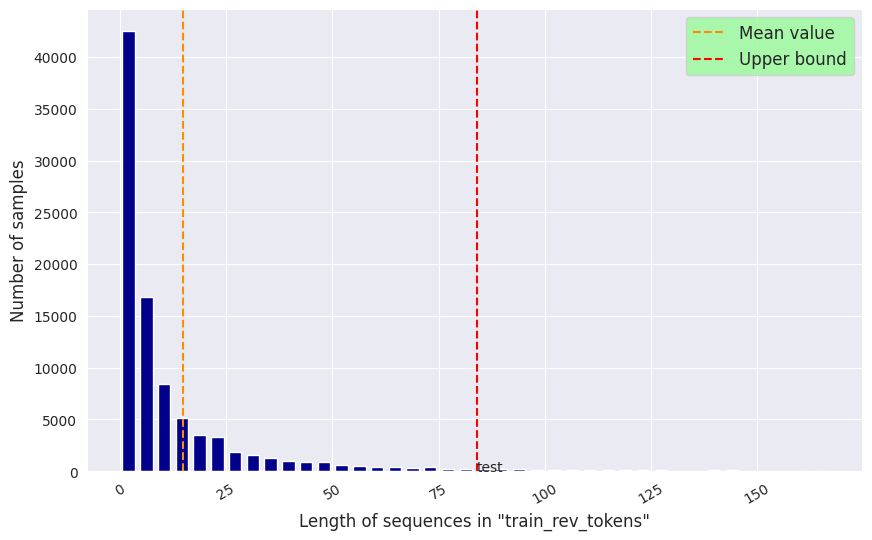

In [ ]:
# find the correct sequence length (check code bc it is exactly the same as the tutorial!!!!!!!!!!!!!)

upper_bound = int(np.mean(seq_lengths) + 2 * np.std(seq_lengths))
percentage = stats.percentileofscore(seq_lengths, upper_bound)

print('The value of upper_bound is %d and the percentage of sequences in "train_tokens" \
of length smaller or equal than upper_bound is %.2f%%.' % (upper_bound, round(percentage, 2)))

# Histogram plot of the lengths of the sequences in "train_tokens"

with sns.axes_style("darkgrid"):

    _, hist = plt.subplots(figsize=(10,6))
    hist.hist(seq_lengths[seq_lengths < 2*upper_bound], color='darkblue', bins=40, rwidth=0.7)
    hist.axvline(np.mean(seq_lengths), color='darkorange', linestyle='--', label='Mean value')
    hist.axvline(upper_bound, color='r', linestyle='--', label='Upper bound')

    plt.xlabel('Length of sequences in "train_tokens"', size='large')
    plt.ylabel('Number of samples', size='large')
    plt.text(upper_bound, 0, 'test')
    plt.legend(fontsize='large')
    plt.xticks(rotation=30)
    plt.show()

In [ ]:
# padding (check code bc it is exactly the same as the tutorial!!!!!!!!!!!!!)

trunc_type = 'post'
padding_type = 'post'

train_pad = pad_sequences(train_tokens, truncating= trunc_type, padding = padding_type, maxlen=upper_bound)
test_pad = pad_sequences(test_tokens, truncating= trunc_type, padding = padding_type, maxlen=upper_bound)
valid_pad = pad_sequences(valid_tokens, truncating= trunc_type, padding = padding_type, maxlen=upper_bound)

print('train_pad.shape:', train_pad.shape)
print('test_pad.shape:', test_pad.shape)
print('valid_pad.shape:', valid_pad.shape, '\n')

idx_pad = random.randint(0, len(train_pad)-1)
print('Review #%d after padding:' %idx_pad + '\n', train_pad[idx_pad])

train_rev_pad.shape: (92505, 84)
test_rev_pad.shape: (39645, 84) 

valid_rev_pad.shape: (56637, 84) 

Review #42065 after padding:
 [ 18 100   1  27  20   2  95   2  27 109 992 174   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0]


## Saving and loading data

In [ ]:
# Save data
with open('/content/drive/MyDrive/DL_Assignment_3/data3_padded.pickle', 'wb') as f:
    pickle.dump((y_train, y_valid, y_test, train_pad, valid_pad, test_pad), f)


In [ ]:
# Load data (for when the kernel crashes)
with open('/content/drive/MyDrive/DL_Assignment_3/data3_padded.pickle', 'rb') as f:
    y_train, y_valid, y_test, train_pad, valid_pad, test_pad= pickle.load(f)

## Converting votes to binary class

In [ ]:
# change y (funny votes) to binary (funny = 1 or not = 0)

print(max(y_train), max(y_valid), max(y_test))

def votes_to_binary(votes, threshold):
  binary_labels = [1 if vote >= threshold else 0 for vote in votes]
  return  np.array(binary_labels)

y_train = votes_to_binary(y_train, 1)
y_test = votes_to_binary(y_test, 1)
y_valid = votes_to_binary(y_valid, 1)

print(max(y_train), max(y_valid), max(y_test))


4615 1843 2529
1 1 1


In [ ]:
# have a look at the distiributions

def calcperc(data):
  total_one = 0
  for i in range(len(data)):
    if data[i]== 1:
      total_one += 1
    perc = total_one / len(data)
  return perc

print('percentage of funny labels for train: ', calcperc(y_train) )
print('percentage of funny labels for valid: ', calcperc(y_valid) )
print('percentage of funny labels for test: ', calcperc(y_test) )

percentage of funny labels for train:  0.033457650937787145
percentage of funny labels for valid:  0.0349771350883698
percentage of funny labels for test:  0.03321982595535376


In [ ]:
# oversample class 1

ros = RandomOverSampler(sampling_strategy=0.2, random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(train_pad, y_train)

## check if the ratio indeed changed

print('percentage of funny labels for train: ', calcperc(y_train) )
print('percentage of funny labels for resampled: ', calcperc(y_train_resampled) )
print('The latter should be higher than the former.../n',
      'now you can change the x_train and y_train')

percentage of funny labels for train:  0.033457650937787145
percentage of funny labels for resampled:  0.16666666666666666
The latter should be higher than the former.../n now you can change the x_train and y_train


## Model

### Metrics for class imbalance and other important things

In [ ]:
dict_size = 35000
batch_size = 2048

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(),
      keras.metrics.Precision(),
      keras.metrics.Recall(),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [ ]:
# Class imbalance

neg = list(y_train).count(0)
pos = list(y_train).count(1)

print('Class 0 counts: ', neg , 'Class 1 counts: ', pos)

Class 0 counts:  89410 Class 1 counts:  3095


In [ ]:
# callback: save metrics

class SaveMetricsCallback(keras.callbacks.Callback):
    def __init__(self, file_path):
        super(SaveMetricsCallback, self).__init__()
        self.file_path = file_path

    def on_epoch_end(self, epoch, logs=None):
        with open(self.file_path, 'a') as f:
            f.write(f"Epoch {epoch + 1} - ")
            f.write(f"Train Loss: {logs['loss']}, Train precission: {logs['precision']}, ")
            f.write(f"TP: {logs['tp']}, FP: {logs['fp']}, TN: {logs['tn']}, FN: {logs['fn']}, ")
            f.write(f"Binary Accuracy: {logs['binary_accuracy']}, Precision: {logs['precision']}, ")
            f.write(f"Recall: {logs['recall']}, AUC: {logs['auc']}, PRC: {logs['prc']}\n")
            f.write(f"Val Loss: {logs['val_loss']}, Val AUC: {logs['val_auc']}\n")
            f.write(f"Val TP: {logs['val_tp']}, Val FP: {logs['val_fp']}, Val TN: {logs['val_tn']}, Val FN: {logs['val_fn']}, ")
            f.write(f"Val Binary Accuracy: {logs['val_binary_accuracy']}, Val Precision: {logs['val_precision']}, ")
            f.write(f"Val Recall: {logs['val_recall']}, Val AUC: {logs['val_auc']}, Val PRC: {logs['val_prc']}\n")

In [ ]:
# callback: early stopping
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

### Model initial: resampling vs not

In [ ]:
embedding_size = 128

model_init = Sequential()
model_init.add(Embedding(dict_size, embedding_size))
model_init.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2))
model_init.add(Dense(1, activation="sigmoid"))
model_init.summary()
model_init.compile(loss="binary_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=0.005), metrics=METRICS)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
hist_init = model_init.fit(x_train_resampled, y_train_resampled, batch_size=batch_size, epochs=10, validation_data=(valid_pad, y_valid))
# this results are accurate

Epoch 1/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 261s 183ms/step - auc: 0.6387 - binary_accuracy: 0.5866 - fn: 23033.0176 - fp: 10473.5859 - loss: 0.6234 - prc: 0.6593 - precision: 0.6180 - recall: 0.4372 - tn: 34319.8086 - tp: 21773.3184 - val_auc: 0.5127 - val_binary_accuracy: 0.8603 - val_fn: 1602.0000 - val_fp: 6312.0000 - val_loss: 0.3891 - val_prc: 0.0431 - val_precision: 0.0566 - val_recall: 0.1913 - val_tn: 48344.0000 - val_tp: 379.0000
Epoch 2/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 265s 186ms/step - auc: 0.9551 - binary_accuracy: 0.8781 - fn: 5179.1357 - fp: 5563.5376 - loss: 0.2687 - prc: 0.9539 - precision: 0.8761 - recall: 0.8819 - tn: 39173.3203 - tp: 39683.7383 - val_auc: 0.5050 - val_binary_accuracy: 0.8266 - val_fn: 1540.0000 - val_fp: 8280.0000 - val_loss: 0.4472 - val_prc: 0.0413 - val_precision: 0.0506 - val_recall: 0.2226 - val_tn: 46376.0000 - val_tp: 441.0000
Epoch 3/10
1398/1398 ━━━━━━━━━━━━━━━━━━━━ 259s 185ms/step - auc: 0.9700 - binary_accuracy: 0.8998 - fn: 4137.6997 - fp

In [ ]:
# 18:21
# NO RESAMPLING

# create folder with current date and time
current_datetime = datetime.now().strftime("%d_%H:%M")
checkpoint_folder = f'/content/drive/MyDrive/DL_Assignment_3/weights_model_{current_datetime}/'
os.makedirs(checkpoint_folder)

# callback: weights per epoch
checkpoint_path_template = os.path.join(checkpoint_folder, 'cp-{epoch:04d}.weights.h5')

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_template,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

# callback: save metrics
metrics_file_path = os.path.join(checkpoint_folder, 'metrics_per_epoch_callback.txt')
save_metrics_callback = SaveMetricsCallback(metrics_file_path)

# model
model_init.save_weights(checkpoint_path_template.format(epoch=0))
hist_init_no_resampling = model_init.fit(train_pad, y_train, batch_size=batch_size, epochs=10, callbacks=[cp_callback, save_metrics_callback,early_stopping_callback], validation_data=(valid_pad, y_valid))

#save architecture/parameters
model_init.save(checkpoint_folder + 'full_model.h5')

clean_memory()

Epoch 1/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - auc: 0.5065 - binary_accuracy: 0.9661 - fn: 1554.9226 - fp: 6.0000 - loss: 0.1604 - prc: 0.0355 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 44902.6172 - tp: 0.0000e+00
Epoch 1: saving model to /content/drive/MyDrive/DL_Assignment_3/weights_model_31_16:22/cp-0001.weights.h5
362/362 ━━━━━━━━━━━━━━━━━━━━ 110s 289ms/step - auc: 0.5065 - binary_accuracy: 0.9661 - fn: 1559.1653 - fp: 6.0000 - loss: 0.1603 - prc: 0.0355 - precision: 0.0000e+00 - recall: 0.0000e+00 - tn: 45025.2109 - tp: 0.0000e+00 - val_auc: 0.5110 - val_binary_accuracy: 0.9650 - val_fn: 1981.0000 - val_fp: 0.0000e+00 - val_loss: 0.1511 - val_prc: 0.0382 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 54656.0000 - val_tp: 0.0000e+00
Epoch 2/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - auc: 0.5144 - binary_accuracy: 0.9665 - fn: 1554.9088 - fp: 2.1050 - loss: 0.1461 - prc: 0.0481 - precision: 0.0023 - recall: 4.4863e-06 - tn: 44906.5117 - tp: 0.01

In [ ]:
plt.plot(hist_init_no_resampling.history['prc'])
plt.plot(hist_init_no_resampling.history['val_prc'])

In [ ]:
plt.plot(hist_init_no_resampling.history['loss'])
plt.plot(hist_init_no_resampling.history['val_loss'])

In [ ]:
# 18:37
# RESAMPLING

clean_memory()

# create folder with current date and time
current_datetime = datetime.now().strftime("%d_%H:%M")
checkpoint_folder = f'/content/drive/MyDrive/DL_Assignment_3/weights_model_{current_datetime}/'
os.makedirs(checkpoint_folder)

# callback: weights per epoch
checkpoint_path_template = os.path.join(checkpoint_folder, 'cp-{epoch:04d}.weights.h5')

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_template,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

# callback: save metrics
metrics_file_path = os.path.join(checkpoint_folder, 'metrics_per_epoch_callback.txt')
save_metrics_callback = SaveMetricsCallback(metrics_file_path)

# model ### NEED TO RESTART MODEL
model_init.save_weights(checkpoint_path_template.format(epoch=0))
hist_init_resampling = model_init.fit(x_train_resampled, y_train_resampled, batch_size=batch_size, epochs=10, callbacks=[cp_callback, save_metrics_callback,early_stopping_callback], validation_data=(valid_pad, y_valid))

#save architecture/parameters
model_init.save(checkpoint_folder + 'full_model.h5')

clean_memory()

Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - auc: 0.5263 - binary_accuracy: 0.8372 - fn: 8692.9004 - fp: 46.9238 - loss: 0.4485 - prc: 0.2081 - precision: 0.7770 - recall: 0.0217 - tn: 44903.0508 - tp: 244.5809
Epoch 1: saving model to /content/drive/MyDrive/DL_Assignment_3/weights_model_31_16:38/cp-0001.weights.h5
420/420 ━━━━━━━━━━━━━━━━━━━━ 136s 308ms/step - auc: 0.5263 - binary_accuracy: 0.8372 - fn: 8713.3135 - fp: 47.0238 - loss: 0.4485 - prc: 0.2082 - precision: 0.7772 - recall: 0.0218 - tn: 45008.5586 - tp: 245.4133 - val_auc: 0.6061 - val_binary_accuracy: 0.9636 - val_fn: 1969.0000 - val_fp: 90.0000 - val_loss: 0.2268 - val_prc: 0.0572 - val_precision: 0.1176 - val_recall: 0.0061 - val_tn: 54566.0000 - val_tp: 12.0000
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - auc: 0.7587 - binary_accuracy: 0.8531 - fn: 6922.8188 - fp: 761.8238 - loss: 0.3714 - prc: 0.4868 - precision: 0.7711 - recall: 0.1755 - tn: 44188.1523 - tp: 2014.6619
Epoch 2: saving model to /co

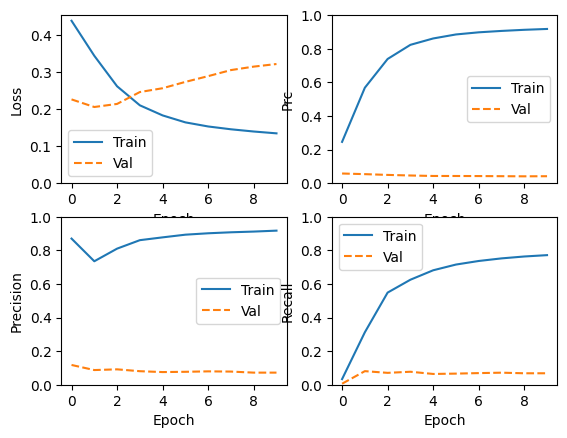

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(hist_init_resampling)

### focal loss

In [ ]:
model_fl = Sequential()

model_fl.add(Embedding(dict_size, 128))
model_fl.add(LSTM(128, return_sequences=True))
model_fl.add(Dropout(0.2))  # Add dropout regularization

model_fl.add(LSTM(32, return_sequences=True))
model_fl.add(Dense(32, activation='relu'))
model_fl.add(Dropout(0.2))  # Add dropout regularization

model_fl.add(LSTM(32))
model_fl.add(Dense(32, activation='relu'))
model_fl.add(Dropout(0.2))  # Add dropout regularization

model_fl.add(Dense(1, activation='sigmoid'))

model_fl.summary()
model_fl.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True),
              optimizer=keras.optimizers.Adam(learning_rate=0.005),
              metrics=METRICS)

In [ ]:
hist_fl = model_fl.fit(x_train_resampled, y_train_resampled, batch_size=batch_size, epochs=10, validation_data=(valid_pad, y_valid))

In [ ]:
def build_model(hp):
    #Optimizer definer
    drop = hp.Choice("Drop",values=[0.2])
    embedding_size = hp.Choice("Embedding_dim",values=[200,400])
    LSTMdim = hp.Choice("Lstm_dim",values=[64,256])
    Densedim = hp.Choice("Dense_dim",values=[64,256])
    hp_learning_rate = hp.Choice("Learning_rate", values=[0.005])

    model = Sequential()
    model.add(Embedding(max_tokens, embedding_size))
    model.add(Bidirectional(LSTM(LSTMdim, return_sequences=True, dropout=drop, recurrent_dropout=drop)))
    model.add(LSTM(LSTMdim, dropout=drop, recurrent_dropout=drop))
    model.add(Dense(Densedim, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True), metrics=METRICS)
    return model

In [ ]:
seed  = 4
max_tokens = 36000 ##### MAY CHANGE
tuner = kt.GridSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    #max_trials=2,
    #executions_per_trial=2,
    overwrite=True,
    directory="tuner_random_search",
    project_name="lr_units",
    seed=seed,
)

tuner.search_space_summary()

In [ ]:
# Hyperparameter optimization
tf.random.set_seed(seed)
np.random.seed(seed)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_rev_pad, y_train, epochs=50, validation_data=(valid_rev_pad, y_valid), callbacks=[stop_early, keras.callbacks.TensorBoard("/tmp/tb_logs")])
#This data use x_train, but it can be augmented or other name of the data

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)
print(tuner.results_summary()) #know the model parameters

### bias initialization (ignore)

In [ ]:
# Calculate initial bias for model

initial_bias = np.log([pos/neg])
initial_bias

array([-3.36344463])

In [ ]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = Sequential([
  Embedding(dict_size, 128),
  LSTM(128, return_sequences=True),
  Dropout(0.2),  # Add dropout regularization
  LSTM(32, return_sequences=True),
  Dense(32, activation='relu'),
  Dropout(0.2), # Add dropout regularization
  LSTM(32),
  Dense(32, activation='relu'),
  Dropout(0.2), # Add dropout regularization
  Dense(1, activation='sigmoid', bias_initializer = output_bias),
  ])

  model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.005),
              metrics=METRICS)

  return model

In [ ]:
model_bias = make_model(output_bias=initial_bias)
#model_bias.predict(train_pad[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[0.03333254],
       [0.03333174],
       [0.03333254],
       [0.03333254],
       [0.03333248],
       [0.03333255],
       [0.03333255],
       [0.03333255],
       [0.03333113],
       [0.03333253]], dtype=float32)

In [ ]:
history_bias =  model_bias.fit(
    x_train_resampled,
    y_train_resampled,
    batch_size=batch_size,
    epochs=10,
    validation_data=(valid_pad, y_valid),
    )

Epoch 1/10
1056/1398 ━━━━━━━━━━━━━━━━━━━━ 3:16 573ms/step - auc: 0.7481 - binary_accuracy: 0.7164 - fn: 17402.4629 - fp: 19007.5273 - loss: 0.7048 - prc: 0.4329 - precision: 0.4351 - recall: 0.4731 - tn: 69537.4219 - tp: 18337.5859

### bias initialization + weights

In [ ]:
# Calculate initial bias for model

initial_bias = np.log([pos/neg])
initial_bias

array([-3.36344463])

In [ ]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)

  model = Sequential([
  Embedding(dict_size, 128),
  LSTM(128, return_sequences=True),
  Dropout(0.2),  # Add dropout regularization
  LSTM(32, return_sequences=True),
  Dense(32, activation='relu'),
  Dropout(0.2), # Add dropout regularization
  LSTM(32),
  Dense(32, activation='relu'),
  Dropout(0.2), # Add dropout regularization
  Dense(1, activation='sigmoid', bias_initializer = output_bias),
  ])

  model.compile(loss=keras.losses.BinaryCrossentropy(),
              optimizer=keras.optimizers.Adam(learning_rate=0.005),
              metrics=METRICS)

  return model

In [ ]:
model_bias = make_model(output_bias=initial_bias)
#model_bias.predict(train_pad[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[0.03333254],
       [0.03333174],
       [0.03333254],
       [0.03333254],
       [0.03333248],
       [0.03333255],
       [0.03333255],
       [0.03333255],
       [0.03333113],
       [0.03333253]], dtype=float32)

In [ ]:
model_bias_weights = make_model(output_bias=initial_bias)
#model_bias_weights.predict(train_pad[:10])


In [ ]:
history_bias_weights =  model_bias_weights.fit(
    x_train_resampled,
    y_train_resampled,
    batch_size=batch_size,
    epochs=10,
    validation_data=(valid_pad, y_valid),
    )

## Hyperparamether tunning

In [ ]:
def build_model(hp):
    #Optimizer definer
    drop = hp.Choice("Drop",values=[0.2])
    embedding_size = hp.Choice("Embedding_dim",values=[128,264])
    LSTMdim = hp.Choice("Lstm_dim",values=[64,128])
    Densedim = hp.Choice("Dense_dim",values=[64,128])
    hp_learning_rate = hp.Choice("Learning_rate", values=[0.005])

    model = Sequential()
    model.add(Embedding(max_tokens, embedding_size))
    model.add(Bidirectional(LSTM(LSTMdim, return_sequences=True, dropout=drop, recurrent_dropout=drop)))
    model.add(LSTM(LSTMdim, dropout=drop, recurrent_dropout=drop))
    model.add(Dense(Densedim, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))
    model.summary()
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True), metrics=METRICS)
    return model

In [ ]:
seed  = 4
max_tokens = 35000 ##### MAY CHANGE
tuner = kt.GridSearch(
    hypermodel=build_model,
    objective="val_loss",
    #max_trials=2,
    #executions_per_trial=2,
    overwrite=True,
    directory="tuner_random_search",
    project_name="lr_units",
    seed=seed,
)

tuner.search_space_summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Search space summary
Default search space size: 5
Drop (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2], 'ordered': True}
Embedding_dim (Choice)
{'default': 128, 'conditions': [], 'values': [128, 264], 'ordered': True}
Lstm_dim (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
Dense_dim (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
Learning_rate (Choice)
{'default': 0.005, 'conditions': [], 'values': [0.005], 'ordered': True}


In [ ]:
# Hyperparameter optimization
tf.random.set_seed(seed)
np.random.seed(seed)

stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


tuner.search(x_train_resampled, y_train_resampled, epochs=30, batch_size=batch_size, validation_data=(valid_pad, y_valid), callbacks=[stop_early, keras.callbacks.TensorBoard("/tmp/tb_logs")])
#This data use x_train, but it can be augmented or other name of the data

best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)
print(tuner.results_summary()) #know the model parameters

Trial 8 Complete [00h 06m 45s]
val_loss: 0.02101271040737629

Best val_loss So Far: 0.02045772783458233
Total elapsed time: 00h 43m 00s
{'Drop': 0.2, 'Embedding_dim': 264, 'Lstm_dim': 64, 'Dense_dim': 128, 'Learning_rate': 0.005}
Results summary
Results in tuner_random_search/lr_units
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0005 summary
Hyperparameters:
Drop: 0.2
Embedding_dim: 264
Lstm_dim: 64
Dense_dim: 128
Learning_rate: 0.005
Score: 0.02045772783458233

Trial 0004 summary
Hyperparameters:
Drop: 0.2
Embedding_dim: 264
Lstm_dim: 64
Dense_dim: 64
Learning_rate: 0.005
Score: 0.02060958370566368

Trial 0003 summary
Hyperparameters:
Drop: 0.2
Embedding_dim: 128
Lstm_dim: 128
Dense_dim: 128
Learning_rate: 0.005
Score: 0.020680466666817665

Trial 0000 summary
Hyperparameters:
Drop: 0.2
Embedding_dim: 128
Lstm_dim: 64
Dense_dim: 64
Learning_rate: 0.005
Score: 0.02068709209561348

Trial 0001 summary
Hyperparameters:
Drop: 0.2
Embedding_dim: 128
Lstm_dim: 64


In [ ]:
model_fl = Sequential()

model_fl.add(Embedding(dict_size, 264))
model_fl.add(LSTM(64, return_sequences=True))
model_fl.add(Dropout(0.2))  # Add dropout regularization

model_fl.add(LSTM(64, return_sequences=True))
model_fl.add(Dense(128, activation='relu'))
model_fl.add(Dropout(0.2))  # Add dropout regularization

model_fl.add(LSTM(64))
model_fl.add(Dense(128, activation='relu'))
model_fl.add(Dropout(0.2))  # Add dropout regularization

model_fl.add(Dense(1, activation='sigmoid'))

model_fl.summary()
model_fl.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(apply_class_balancing=True),
              optimizer=keras.optimizers.Adam(learning_rate=0.005),
              metrics=METRICS)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Best parameters

# create folder with current date and time
current_datetime = datetime.now().strftime("%d_%H:%M")
checkpoint_folder = f'/content/drive/MyDrive/DL_Assignment_3/weights_model_{current_datetime}/'
os.makedirs(checkpoint_folder)

batch_size = 1028
early_stopping_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# callback: weights per epoch
checkpoint_path_template = os.path.join(checkpoint_folder, 'cp-{epoch:04d}.weights.h5')

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path_template,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch'
)

# callback: save metrics
metrics_file_path = os.path.join(checkpoint_folder, 'metrics_per_epoch_callback.txt')
save_metrics_callback = SaveMetricsCallback(metrics_file_path)

# model
model_fl.save_weights(checkpoint_path_template.format(epoch=0))
hist_best = model_fl.fit(x_train_resampled, y_train_resampled, batch_size=batch_size, epochs=50, callbacks=[cp_callback, save_metrics_callback, early_stopping_callback], validation_data=(valid_pad, y_valid))

#save architecture/parameters
model_fl.save(checkpoint_folder + 'full_model.h5')

clean_memory()

Epoch 1/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - auc: 0.5199 - binary_accuracy: 0.9010 - fn: 10698.7207 - fp: 860.5865 - loss: 0.0498 - prc: 0.1253 - precision: 0.2087 - recall: 0.0251 - tn: 98814.7500 - tp: 232.9423
Epoch 1: saving model to /content/drive/MyDrive/DL_Assignment_3/weights_model_31_19:18/cp-0001.weights.h5
105/105 ━━━━━━━━━━━━━━━━━━━━ 16s 100ms/step - auc: 0.5199 - binary_accuracy: 0.9005 - fn: 10864.1982 - fp: 860.9151 - loss: 0.0497 - prc: 0.1259 - precision: 0.2106 - recall: 0.0250 - tn: 99651.9844 - tp: 235.9811 - val_auc: 0.5106 - val_binary_accuracy: 0.9650 - val_fn: 1981.0000 - val_fp: 0.0000e+00 - val_loss: 0.0228 - val_prc: 0.0393 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 54656.0000 - val_tp: 0.0000e+00
Epoch 2/50
104/105 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - auc: 0.5227 - binary_accuracy: 0.8394 - fn: 8629.1543 - fp: 18.0865 - loss: 0.0426 - prc: 0.2229 - precision: 0.9223 - recall: 0.0313 - tn: 45001.2500 - tp: 321.5096
Epoch 2: saving

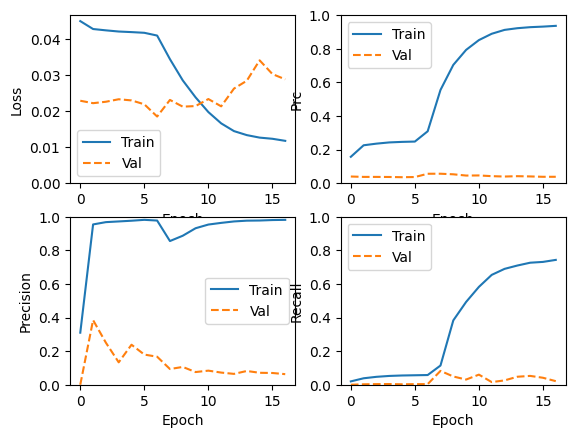

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

plot_metrics(hist_best)